In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/significance-measure-of-product-search/product_descriptions.csv
/kaggle/input/significance-measure-of-product-search/sample_submission.csv
/kaggle/input/significance-measure-of-product-search/relevance_instructions.docx
/kaggle/input/significance-measure-of-product-search/attributes.csv
/kaggle/input/significance-measure-of-product-search/train.csv
/kaggle/input/significance-measure-of-product-search/test.csv


In [2]:
import re
import nltk
import time
import pandas as pd
import numpy as np

In [3]:
train_data = pd.read_csv("../input/significance-measure-of-product-search/train.csv", encoding="ISO-8859-1")
test_data = pd.read_csv("../input/significance-measure-of-product-search/test.csv", encoding="ISO-8859-1")
attributes = pd.read_csv("../input/significance-measure-of-product-search/attributes.csv")
product_des = pd.read_csv("../input/significance-measure-of-product-search/product_descriptions.csv")


In [5]:
print("there are in total {} products ".format(len(test_data.product_title.unique())))
print("there are in total {} search query ".format(len(test_data.search_term.unique())))
print("there are in total {} product_uid".format(len(test_data.product_uid.unique())))

there are in total 94731 products 
there are in total 22427 search query 
there are in total 97460 product_uid


In [4]:
print("there are in total {} products ".format(len(train_data.product_title.unique())))
print("there are in total {} search query ".format(len(train_data.search_term.unique())))
print("there are in total {} product_uid".format(len(train_data.product_uid.unique())))

there are in total 53489 products 
there are in total 11795 search query 
there are in total 54667 product_uid


In [6]:
print("there are in total {} product_uid ".format(len(product_des.product_uid.unique())))
print("there are in total {} product_descriptions ".format(len(product_des.product_description.unique())))

there are in total 124428 product_uid 
there are in total 110128 product_descriptions 


In [7]:
high_relevance = train_data.loc[train_data["relevance"] == 3]
high_relevance[['product_title', 'search_term']].head()
high_relevance.head(10)

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.0
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.0
5,18,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,convection otr,3.0
7,21,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,microwaves,3.0
9,27,100009,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...,mdf 3/4,3.0
11,35,100011,Toro Personal Pace Recycler 22 in. Variable Sp...,briggs and stratton lawn mower,3.0
12,37,100011,Toro Personal Pace Recycler 22 in. Variable Sp...,gas mowe,3.0
16,65,100016,Sunjoy Calais 8 ft. x 5 ft. x 8 ft. Steel Tile...,grill gazebo,3.0
32,123,100023,Quikrete 80 lb. Crack-Resistant Concrete,CONCRETE & MASONRY CLEANER & ETCHER,3.0
43,162,100029,DecoArt Americana Decor 16-oz. Whisper Chalky ...,chalk paint,3.0


In [8]:
train_data = pd.merge(train_data, product_des, on='product_uid')
test_data = pd.merge(test_data, product_des, on='product_uid')

In [9]:
train_data.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...


In [10]:
train_data.iloc[0]['search_term'] + '/' + train_data.iloc[0]['product_title'] + '/'+ train_data.iloc[0]['product_description']

'angle bracket/Simpson Strong-Tie 12-Gauge Angle/Not only do angles make joints stronger, they also provide more consistent, straight corners. Simpson Strong-Tie offers a wide variety of angles in various sizes and thicknesses to handle light-duty jobs or projects where a structural connection is needed. Some can be bent (skewed) to match the project. For outdoor projects or those where moisture is present, use our ZMAX zinc-coated connectors, which provide extra resistance against corrosion (look for a "Z" at the end of the model number).Versatile connector for various 90 connections and home repair projectsStronger than angled nailing or screw fastening aloneHelp ensure joints are consistently straight and strongDimensions: 3 in. x 3 in. x 1-1/2 in.Made from 12-Gauge steelGalvanized for extra corrosion resistanceInstall with 10d common nails or #9 x 1-1/2 in. Strong-Drive SD screws'

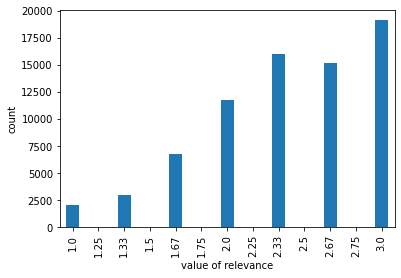

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
distribution = train_data['relevance'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
plt.ylabel('count')
plt.xlabel('value of relevance')
distribution.plot(kind = 'bar')
plt.show()

<AxesSubplot:title={'center':'test'}>

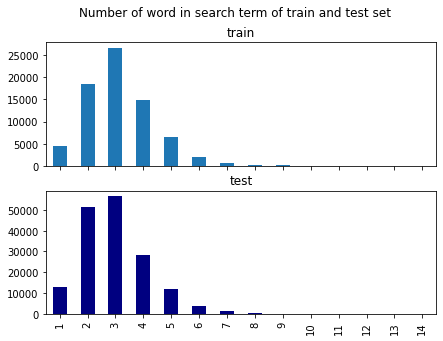

In [12]:
distribution_train = train_data.search_term.str.split().apply(len).value_counts().sort_index()
distribution_test = test_data.search_term.str.split().apply(len).value_counts().sort_index()
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('Number of word in search term of train and test set')

distribution_train.plot(kind = 'bar', sharex = 1, figsize = (7,5), ax = ax1, title = 'train')
distribution_test.plot(kind = 'bar', colormap = 'jet', figsize = (7, 5), ax = ax2, title = 'test')

<AxesSubplot:title={'center':'test'}>

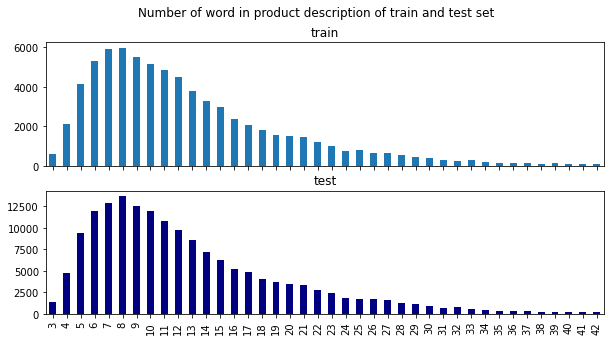

In [13]:
distribution_train = train_data.product_description.str.split().apply(len).divmod(10)[0].value_counts().nlargest(40).sort_index()
distribution_test = test_data.product_description.str.split().apply(len).divmod(10)[0].value_counts().nlargest(40).sort_index()
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('Number of word in product description of train and test set')

distribution_train.plot(kind = 'bar', sharex = 1, figsize = (10,5), ax = ax1, title = 'train')
distribution_test.plot(kind = 'bar', colormap = 'jet', figsize = (10, 5), ax = ax2, title = 'test')

In [14]:
print(len(train_data),' ',len(test_data))
test_data.tail()

74067   166693


,id,product_uid,product_title,search_term,product_description
166688,240756,224424,stufurhome Norma 24 in. W x 16 in. D x 34 in. ...,24 whtie storage cabinet,Create a neat yet stylish storage space for or...
166689,240757,224425,Home Decorators Collection 49 in. D Alessandro...,adirondeck cusion,Our Bullnose Adirondack Chair Cushions fit Adi...
166690,240758,224426,Simpson Strong-Tie HB 3-1/2 x 14 in. Top Flang...,hb,Joist hangers are designed to provide support ...
166691,240759,224427,1/4 in. -20 tpi x 1-1/2 in. Stainless Steel Bu...,hex sockets,These socket cap screws are ideal for applicat...
166692,240760,224428,Bosch 4 in. Bi-Metal Hole Saw,4 inch hole saw,The Bosch quick change bi-metal hole saws feat...


In [15]:
brand_attr = attributes[attributes.name == "MFG Brand Name"][["product_uid", "value"]].rename(columns={"value": "brand"})
brand_attr.drop_duplicates(subset=['product_uid'], inplace = True)
train_data = pd.merge(train_data, brand_attr, on='product_uid',  how='left').fillna('')
test_data = pd.merge(test_data, brand_attr, on='product_uid',  how='left').fillna('')


In [16]:
train_data.head()

,id,product_uid,product_title,search_term,relevance,product_description,brand
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,Delta
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,Delta


In [17]:
print(len(train_data),' ',len(test_data))
test_data.tail()

74067   166693


,id,product_uid,product_title,search_term,product_description,brand
166688,240756,224424,stufurhome Norma 24 in. W x 16 in. D x 34 in. ...,24 whtie storage cabinet,Create a neat yet stylish storage space for or...,stufurhome
166689,240757,224425,Home Decorators Collection 49 in. D Alessandro...,adirondeck cusion,Our Bullnose Adirondack Chair Cushions fit Adi...,Home Decorators Collection
166690,240758,224426,Simpson Strong-Tie HB 3-1/2 x 14 in. Top Flang...,hb,Joist hangers are designed to provide support ...,
166691,240759,224427,1/4 in. -20 tpi x 1-1/2 in. Stainless Steel Bu...,hex sockets,These socket cap screws are ideal for applicat...,
166692,240760,224428,Bosch 4 in. Bi-Metal Hole Saw,4 inch hole saw,The Bosch quick change bi-metal hole saws feat...,Bosch


In [18]:
from gensim.utils import simple_preprocess, tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english')) 
wordnet_lemmatizer = WordNetLemmatizer()
import json
import warnings; warnings.filterwarnings("ignore");

strNum = {'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9}
def str_stem(s): 
    if isinstance(s, str):
        #fix strong.Bullet strongBullet
        s = re.sub(r"(\w)\.([A-Z])", r"\1 \2", s)
        s = re.sub(r"([a-z])([A-Z])", r"\1 \2", s)
        s = re.sub(r"([0-9])( *)\.( *)([0-9])", r"\1.\4", s)
        #stem unit of measurement
        s = re.sub(r"([0-9]+)( *)(inches|inch|in|')\.?", r"\1in. ", s)
        s = re.sub(r"([0-9]+)( *)(foot|feet|ft|'')\.?", r"\1ft. ", s)
        s = re.sub(r"([0-9]+)( *)(pounds|pound|lbs|lb)\.?", r"\1lb. ", s)
        s = re.sub(r"([0-9]+)( *)(square|sq) ?\.?(feet|foot|ft)\.?", r"\1sq.ft. ", s)
        s = re.sub(r"([0-9]+)( *)(cubic|cu) ?\.?(feet|foot|ft)\.?", r"\1cu.ft. ", s)
        s = re.sub(r"([0-9]+)( *)(gallons|gallon|gal)\.?", r"\1gal. ", s)
        s = re.sub(r"([0-9]+)( *)(ounces|ounce|oz)\.?", r"\1oz. ", s)
        s = re.sub(r"([0-9]+)( *)(centimeters|cm)\.?", r"\1cm. ", s)
        s = re.sub(r"([0-9]+)( *)(milimeters|mm)\.?", r"\1mm. ", s)
        s = re.sub(r"([0-9]+)( *)(°|degrees|degree)\.?", r"\1 deg. ", s)
        s = re.sub(r"([0-9]+)( *)(v|volts|volt)\.?", r"\1 volt. ", s)
        s = re.sub(r"([0-9]+)( *)(wattage|watts|watt)\.?", r"\1 watt. ", s)
        s = re.sub(r"([0-9]+)( *)(amperes|ampere|amps|amp)\.?", r"\1 amp. ", s)
        s = re.sub(r"([0-9]+)( *)(qquart|quart)\.?", r"\1 qt. ", s)
        s = re.sub(r"([0-9]+)( *)(hours|hour|hrs.)\.?", r"\1 hr ", s)
        s = re.sub(r"([0-9]+)( *)(gallons per minute|gallon per minute|gal per minute|gallons/min.|gallons/min)\.?", r"\1 gal. per min. ", s)
        s = re.sub(r"([0-9]+)( *)(gallons per hour|gallon per hour|gal per hour|gallons/hour|gallons/hr)\.?", r"\1 gal. per hr ", s)
        # Deal with special characters
        s = s.replace("$"," ")
        s = s.replace("?"," ")
        s = s.replace("&nbsp;"," ")
        s = s.replace("&amp;","&")
        s = s.replace("&#39;","'")
        s = s.replace("/>/Agt/>","")
        s = s.replace("</a<gt/","")
        s = s.replace("gt/>","")
        s = s.replace("/>","")
        s = s.replace("<br","")
        s = s.replace("<.+?>","")
        s = s.replace("[ &<>)(_,;:!?\+^~@#\$]+"," ")
        s = s.replace("'s\\b","")
        s = s.replace("[']+","")
        s = s.replace("[\"]+","")
        s = s.replace("-"," ")
        s = s.replace("+"," ")
        s = s.replace("..",".")
        s = s.replace(",","") #could be number / segment later
        s = s.replace("-"," ")
        s = s.replace("//","/")
        s = s.replace("/"," ")
        s = s.replace("..",".")
        s = s.replace(" / "," ")
        s = s.replace(" \\ "," ")
        s = s.replace("."," . ")
        s = s.replace("  "," ")
        s = re.sub(r"(^\.|/)", r"", s)
        s = re.sub(r"(\.|/)$", r"", s)
        s = re.sub(r"([0-9])([a-z])", r"\1 \2", s)
        s = re.sub(r"([a-z])([0-9])", r"\1 \2", s)
        s = re.sub(r"([a-z])( *)\.( *)([a-z])", r"\1 \4", s)
        s = re.sub(r"([a-z])( *)/( *)([a-z])", r"\1 \4", s)
        s = s.replace("*"," xbi ")
        s = s.replace(" by "," xbi ")

        s = (" ").join([str(strNum[z]) if z in strNum else z for z in s.split(" ")])
        s = " ".join([re.sub('[^A-Za-z0-9-./]', ' ', word) for word in s.lower().split()])
        return s
    else:
        return "null"



In [20]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 2.2 MB/s eta 0:00:0000:0100:010m


In [21]:
from spellchecker import SpellChecker
spell = SpellChecker()

In [22]:
import gensim
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess, tokenize
stop_words = set(stopwords.words('english')) 
wordnet_lemmatizer = WordNetLemmatizer()
gensim.utils.tokenize
def preprocessing(doc, correction = 0):
    words = []
    doc  = str_stem(doc)
    for word in doc.split(' '):
        if word not in stop_words:
            if correction == 1:
                if len(spell.unknown([word])):
                    word = spell.correction(word)
            word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
            word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
            word3 = wordnet_lemmatizer.lemmatize(word2, pos = ("a"))
            words.append(word3)
    return ' '.join(words)

In [23]:
features = pd.concat((train_data, test_data), axis=0, ignore_index=True)
print(str(len(train_data)) + ' ' + str(len(test_data)) + ' ' + str(len(features)))
del train_data
del test_data

74067 166693 240760


In [24]:
import pickle
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from keras.layers import *
import gensim
from time import time
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess, tokenize



In [25]:
features['brand'] = features['brand'].replace(np.nan, '', regex=True)

In [26]:
import pickle
import keras as kr
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from keras.layers import *
import spacy
import re
import math 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder



In [27]:
for col in features.columns:
  print('{} - {} null values'.format(col, features[col].isna().values.sum()))

id - 0 null values
product_uid - 0 null values
product_title - 0 null values
search_term - 0 null values
relevance - 166693 null values
product_description - 0 null values
brand - 0 null values


In [28]:
print(str(len(features)))

240760


In [29]:
pip install textdistance

Note: you may need to restart the kernel to use updated packages.


In [31]:
import textdistance
#with description
features["jaccard_similar_desc"] = [textdistance.jaccard(features["search_term"][i], features["product_description"][i]) for i in range(0, len(features))]
features["levenshtein_similarz_desc"] = [textdistance.levenshtein(features["search_term"][i], features["product_description"][i]) for i in range(0, len(features))]
#with title
features["jaccard_similar_title"] = [textdistance.jaccard(features["search_term"][i], features["product_title"][i]) for i in range(0, len(features))]
features["levenshtein_similarz_title"] = [textdistance.levenshtein(features["search_term"][i], features["product_title"][i]) for i in range(0, len(features))]
#with brand
features["jaccard_similar_brand"] = [textdistance.jaccard(features["search_term"][i], features["brand"][i]) for i in range(0, len(features))]
features["levenshtein_similarz_brand"] = [textdistance.levenshtein(features["search_term"][i], features["brand"][i]) for i in range(0, len(features))]


In [32]:
features.head()

,id,product_uid,product_title,search_term,relevance,product_description,brand,jaccard_similar_desc,levenshtein_similarz_desc,jaccard_similar_title,levenshtein_similarz_title,jaccard_similar_brand,levenshtein_similarz_brand
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,0.015348,834,0.243243,27,0.240000,16
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,0.010626,838,0.166667,29,0.173913,16
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver,0.008167,1093,0.113924,72,0.258065,24
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,Delta,0.023055,678,0.189873,65,0.105263,14
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,Delta,0.025937,676,0.200000,63,0.210526,15


In [33]:
import xgboost
import gensim
from time import time
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess, tokenize
from nltk.corpus import brown
embed_model = gensim.models.Word2Vec(brown.sents())
embed_model.save('brown.embedding')
model = gensim.models.Word2Vec.load('brown.embedding')

In [35]:
%%time
def embeding_similarity_calculator(s, t, i):
    _sum = 0
    avg = 0
    if len(s.split()) == 0 :
        return 0
    for s_word in s.split():
        _max = 0
        for t_word in t.split():
            if ((s_word in model.wv) and (t_word in model.wv)):
                _max = max(_max, model.wv.similarity(s_word, t_word))
        _sum += _max
    avg = _sum/ len(s.split())
    return avg
features["word_ebed_similarity"] = [embeding_similarity_calculator(features["search_term"][i], features["product_description"][i], i) for i in range(0, len(features))]

CPU times: user 19min 27s, sys: 165 ms, total: 19min 27s
Wall time: 19min 28s


In [ ]:
tfidf_vect = TfidfVectorizer(analyzer='char_wb', ngram_range = (3,3), max_features = 1500)
tfidf_des = tfidf_vect.fit_transform(features.product_description).toarray()
tfidf_search = tfidf_vect.transform(features.search_term).toarray()


outfile = open("tfidf_des",'wb')
pickle.dump(tfidf_des, outfile)
outfile = open("tfidf_search",'wb')
pickle.dump(tfidf_search, outfile)

In [ ]:
import spacy
from scipy.spatial import distance
features["tfidf_cosine_distance"] = [distance.cosine(tfidf_search[i], tfidf_des[i]) for i in range(0, len(tfidf_des))]

In [ ]:

outfile = open("features_18_4",'wb')
pickle.dump(features, outfile)

In [ ]:
import pandas as pd
features = pd.DataFrame(features).fillna(0)
mod_train = features.iloc[:74067]
mod_test = features.iloc[74067:]
y_train = mod_train['relevance']
mod_train = mod_train.drop(columns=['product_title','product_description','brand','search_term','relevance'])
mod_test = mod_test.drop(columns=['product_title','product_description','brand','search_term', 'relevance'])

In [ ]:
print(len(mod_train), ' ',len(mod_test))

In [ ]:
mod_train = mod_train.sort_values('product_uid')

In [ ]:
mod_train.head()

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

def modelEvaluate(model, X_train, y_train, x_val, y_val, label_encode = None):
    model.fit(X_train, y_train)
    pred = model.predict(x_val)
    _pred = pred
    _y_val = y_val
    if label_encode is not None:
        _y_val = label_encode.inverse_transform(_y_val)
        _pred = label_encode.inverse_transform(_pred)
    mae, mse = (mean_absolute_error(_pred, _y_val),mean_squared_error(_pred, _y_val))
    return (mae, mse)

In [ ]:
from sklearn.model_selection import KFold
import math 
def crossValidate(model, label_encoder = None):
    mae_score = []
    mse_score = []
    kf = KFold(n_splits=4)
    kf.get_n_splits(mod_train)
    for train_index, test_index in kf.split(mod_train):
        X, X_test = mod_train.iloc[train_index], mod_train.iloc[test_index]
        y, y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        (mae, mse) = modelEvaluate(model, X, y, X_test, y_test, label_encode = label_encoder)
        mae_score.append(mae)
        mse_score.append(mse)
    return [sum(mae_score)/len(mae_score), math.sqrt(sum(mse_score)/len(mse_score))]

In [ ]:
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn import linear_model
import xgboost
from xgboost import XGBRegressor
result = []
result.append(('RandomForest',crossValidate(RandomForestRegressor(n_estimators=700, max_depth=6, random_state=42))))
result.append(('XGBoost',crossValidate(XGBRegressor(colsample_bytree=0.4,       
                 learning_rate=0.1,
                 max_depth=6,
                 n_estimators=700,                                                                    
                 reg_alpha=0.075,
                 reg_lambda=0.045,
                 subsample=0.6,
                 seed=42))))
result.append(('GradientBoosting',crossValidate(GradientBoostingRegressor(n_estimators=700, max_depth=6, random_state=42))))

In [ ]:
result

In [ ]:
%%time
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge
estimators = [  ('RandomForest', RandomForestRegressor(n_estimators=700, max_depth=6, random_state=42)),
                ('XGBoost', XGBRegressor(colsample_bytree=0.4,learning_rate=0.1,max_depth=6,n_estimators=700,reg_alpha=0.075,reg_lambda=0.045,subsample=0.6,seed=42)),                                                                    
               
             ]
stacked_reg = StackingRegressor(
        estimators=estimators,
        final_estimator=BayesianRidge()
    )
result.append(('StackedBayesianRidge',crossValidate(stacked_reg)))

In [ ]:
labels = []
mae = []
rmse = []
for _name, _score in result:
    labels.append(_name)
    mae.append(_score[0])
    rmse.append(_score[1])

#Plotting
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(15,6))
rects1 = ax.bar(x - width/2, mae, width, label='MAE')
rects2 = ax.bar(x + width/2, rmse, width, label='RMSE')

ax.set_ylabel('Scores')
ax.set_title('Scores by models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [ ]:
y_train = features.iloc[:74067]['relevance']

In [ ]:
stacked_reg.fit(mod_train, y_train)
pred = stacked_reg.predict(mod_test)
pred.shape

In [ ]:

submission = pd.read_csv("../input/significance-measure-of-product-search/sample_submission.csv", encoding="ISO-8859-1")
pred = [min(3,i) for i in pred]
pred = [max(1, i) for i in pred]
submission['relevance'] = pred
submission.to_csv('submission.csv', index=False)

In [ ]:
rf = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=42)
rf.fit(mod_train, y_train)
fi = pd.DataFrame({'feature': mod_train.columns, 'importance': rf.feature_importances_}).sort_values(by='importance', ascending=False)
fi = fi.reset_index()
fi.head(20)